In [175]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
from rdkit.Chem import DataStructs
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import pandas as pd
import numpy as np
np.random.seed(1779177)
import os
#import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
drug_c = pd.read_csv("drugCentral.csv")
endogenous = pd.read_csv("endogenous.csv")
in_trails = pd.read_csv("in-trials.csv")
world = pd.read_csv("world.csv")
data = pd.read_csv("Bioactivities.csv",sep='\t')
data1 = pd.read_csv("Bioactivities1.csv", sep=';',low_memory=False)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7870 entries, 0 to 7869
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 7870 non-null   int64  
 1   activity_comment           7719 non-null   object 
 2   activity_id                7870 non-null   int64  
 3   activity_properties        7870 non-null   object 
 4   assay_chembl_id            7870 non-null   object 
 5   assay_description          7870 non-null   object 
 6   assay_type                 7870 non-null   object 
 7   bao_endpoint               7870 non-null   object 
 8   bao_format                 7870 non-null   object 
 9   bao_label                  7870 non-null   object 
 10  canonical_smiles           7835 non-null   object 
 11  data_validity_comment      4 non-null      object 
 12  data_validity_description  4 non-null      object 
 13  document_chembl_id         7870 non-null   objec

In [116]:
df1 = pd.read_csv('Bioactivities2.csv',sep='\t',low_memory=False)

In [117]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64726 entries, 0 to 64725
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  64726 non-null  int64  
 1   Molecule ChEMBL ID          64726 non-null  object 
 2   Molecule Max Phase          64726 non-null  int64  
 3   Molecular Weight            64726 non-null  float64
 4   #RO5 Violations             64726 non-null  object 
 5   AlogP                       64726 non-null  object 
 6   Compound Key                64726 non-null  object 
 7   Smiles                      64726 non-null  object 
 8   Standard Type               64726 non-null  object 
 9   Standard Relation           64726 non-null  object 
 10  Standard Value              64726 non-null  float64
 11  Standard Units              64726 non-null  object 
 12  Uo Units                    64726 non-null  object 
 13  Potential Duplicate         647

<AxesSubplot:>

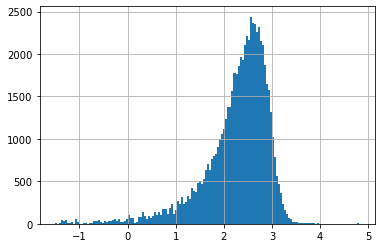

In [145]:
df1['logValue'].hist(bins=150)

In [107]:
df = data.dropna(subset=['canonical_smiles', 'molecule_chembl_id']).drop_duplicates(subset=['molecule_chembl_id'])
df1 = data1.dropna(subset=['Smiles', 'Molecule ChEMBL ID']).drop_duplicates(subset=['Molecule ChEMBL ID'])

In [108]:
df_activity = df.loc[(df['type'] == 'Potency') & (df['standard_units'] == 'nM')].dropna(subset=['value'])
df_activity['logValue'] = df_activity['value']

df_activity1 = df1.loc[(df1['Standard Type'] == 'Inhibition') & (df1['Standard Units'] == '%')].dropna(subset=['Standard Value'])
df_activity1['logValue'] = df_activity1['Standard Value']

In [109]:
df_activity1.sort_values("logValue", ascending=False)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,logValue
23914,CHEMBL3474872,NaN,0,338.41,0,3.54,DDD01246174,CCc1[nH]c2c(CNc3cncc(C(=O)OC)n3)cc(C)cc2c1C,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,122.98
3576,CHEMBL3480655,NaN,0,309.79,0,1.98,DDD01251988,O=C(N1CCOCC(O)C1)C1(c2ccc(Cl)cc2)CCC1,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,122.98
14735,CHEMBL3481775,NaN,0,328.40,0,1.76,DDD01253114,Cc1nc(CN(C)C(=O)c2ccc(Cn3cnnn3)cc2)cs1,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,122.98
54931,CHEMBL3465371,NaN,0,309.42,0,2.78,DDD01076406,Cc1cnn(CCNCc2c(C)nn(-c3ccccc3)c2C)c1,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,121.12
32246,CHEMBL3465370,NaN,0,277.39,0,2.84,DDD01076405,CC(C)Cc1ncc(CNc2cnccc2CO)s1,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,121.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21318,CHEMBL3441698,NaN,0,352.44,0,2.99,DDD01031380,COCCn1cc(-c2cc(C(=O)N3CCCC3)c3ccccn23)nc1C,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,-327.57
67168,CHEMBL3499865,NaN,0,457.41,0,0.45,DDD01032496,CC(=O)NCC(=O)N1Cc2nccn2CC(COc2cccnc2)C1.O=C(O)...,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,-428.77
8753,CHEMBL3449343,NaN,0,274.37,0,1.24,DDD01059923,CCC(=O)N1CCC(c2ncc3c(n2)CCNC3)CC1,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,-470.55
20076,CHEMBL3461345,NaN,0,349.44,0,2.71,DDD01072324,Cc1cc(N2CCC(N(C)C(=O)c3ccc(C#N)cc3)CC2)nc(C)n1,Inhibition,'=',...,"Methionyl-tRNA synthetase, putative",Leishmania donovani (strain BPK282A1),SINGLE PROTEIN,CHEMBL3988442,33,Gates Library compound collection,NaN,NaN,None,-815.09


In [37]:
df['mol'] = df['canonical_smiles'].apply(Chem.MolFromSmiles)

In [90]:
# df1['mol'] = df1['Smiles'].apply(Chem.MolFromSmiles)

In [38]:
# df = df.dropna(subset=['mol'])
# df['HeavyAtomCount'] = df['mol'].apply(Descriptors.HeavyAtomCount)
# df['HAccept'] = df['mol'].apply(Descriptors.NumHAcceptors)
# df['HDonor'] = df['mol'].apply(Descriptors.NumHDonors)
# df['Heteroatoms'] = df['mol'].apply(Descriptors.NumHeteroatoms)
# df['RingCount'] = df['mol'].apply(Descriptors.RingCount)
# df['SaturatedRings'] = df['mol'].apply(Descriptors.NumSaturatedRings)
# df['AliphaticRings'] = df['mol'].apply(Descriptors.NumAliphaticRings)
# df['AromaticRings'] = df['mol'].apply(Descriptors.NumAromaticRings)
# df['Ipc'] = df['mol'].apply(Descriptors.Ipc)
# df['HallKierAlpha'] = df['mol'].apply(Descriptors.HallKierAlpha)
# df['NumValenceElectrons'] = df['mol'].apply(Descriptors.NumValenceElectrons)
# df['MolLogP'] = df['mol'].apply(Descriptors.MolLogP)
# df['AMW'] = df['mol'].apply(Descriptors.MolWt)
# df['NumRotatableBonds'] = df['mol'].apply(Descriptors.NumRotatableBonds)
# # df["ECFP6"] = df['mol'].apply(AllChem.GetMorganFingerprintAsBitVect, args=(3, 2048))
# # df["RDKFP"] = df['mol'].apply(AllChem.RDKFingerprint, fpSize=2048)

In [92]:
df1 = df1.dropna(subset=['mol'])
df1['HeavyAtomCount'] = df1['mol'].apply(Descriptors.HeavyAtomCount)
df1['HAccept'] = df1['mol'].apply(Descriptors.NumHAcceptors)
df1['HDonor'] = df1['mol'].apply(Descriptors.NumHDonors)
df1['Heteroatoms'] = df1['mol'].apply(Descriptors.NumHeteroatoms)
df1['RingCount'] = df1['mol'].apply(Descriptors.RingCount)
df1['SaturatedRings'] = df1['mol'].apply(Descriptors.NumSaturatedRings)
df1['AliphaticRings'] = df1['mol'].apply(Descriptors.NumAliphaticRings)
df1['AromaticRings'] = df1['mol'].apply(Descriptors.NumAromaticRings)
df1['Ipc'] = df1['mol'].apply(Descriptors.Ipc)
df1['HallKierAlpha'] = df1['mol'].apply(Descriptors.HallKierAlpha)
df1['NumValenceElectrons'] = df1['mol'].apply(Descriptors.NumValenceElectrons)
df1['MolLogP'] = df1['mol'].apply(Descriptors.MolLogP)
df1['AMW'] = df1['mol'].apply(Descriptors.MolWt)
df1['NumRotatableBonds'] = df1['mol'].apply(Descriptors.NumRotatableBonds)
# df1["ECFP6"] = df1['mol'].apply(AllChem.GetMorganFingerprintAsBitVect, args=(3, 2048))
# df1["RDKFP"] = df1['mol'].apply(AllChem.RDKFingerprint, fpSize=2048)

In [110]:
df1['logValue'] = 1 * np.log(df_activity1['logValue'])

/home/moazmohamed/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/moazmohamed/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [133]:
df1 = df1.dropna(subset=['logValue'])

In [111]:
df1 = df1.replace([np.inf, -np.inf], np.nan).dropna(subset=['logValue'], how="all")


In [115]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64726 entries, 0 to 68625
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          64726 non-null  object 
 1   Molecule Name               3 non-null      object 
 2   Molecule Max Phase          64726 non-null  int64  
 3   Molecular Weight            64726 non-null  object 
 4   #RO5 Violations             64726 non-null  object 
 5   AlogP                       64726 non-null  object 
 6   Compound Key                64726 non-null  object 
 7   Smiles                      64726 non-null  object 
 8   Standard Type               64726 non-null  object 
 9   Standard Relation           64726 non-null  object 
 10  Standard Value              64726 non-null  float64
 11  Standard Units              64726 non-null  object 
 12  pChEMBL Value               0 non-null      float64
 13  Data Validity Comment       0 n

<AxesSubplot:>

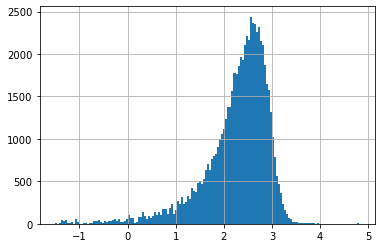

In [118]:
df1['logValue'].hist(bins=150)


<AxesSubplot:>

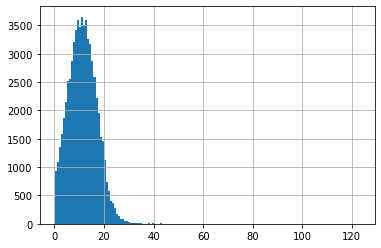

In [102]:
df1['Standard Value'].hist(bins=150)

In [61]:
# df = df.loc[(df['type'] == 'Potency') & (df['standard_units'] == 'nM')].dropna(subset=['value'])

# X = df[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
#        'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
#        'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
#        'NumValenceElectrons']]
# y= df['logValue']

In [119]:
#df1 = df1.loc[(df1['Standard Type'] == 'Inhibition') & (df1['Standard Units'] == '%')].dropna(subset=['Standard Value'])

X1 = df1[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']]
y1 = df1['logValue']
#y1 = 1 * np.log(df_activity1['logValue'])

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
scaler_xtrain = RobustScaler()
scaler_ytrain = RobustScaler()
scaler_xvalid = RobustScaler()
scaler_yvalid = RobustScaler()

# X[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
#        'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
#        'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
#        'NumValenceElectrons']] = scaler_x.fit_transform(X[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
#        'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
#        'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
#        'NumValenceElectrons']])


# y = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))


# X1[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
#        'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
#        'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
#        'NumValenceElectrons']] = scaler_x1.fit_transform(X1[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
#        'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
#        'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
#        'NumValenceElectrons']])


# y1 = scaler_y1.fit_transform(y1.to_numpy().reshape(-1,1))

In [122]:
# y= X['logValue']
# X = X.drop(columns='logValue')
y1

0        2.596001
1        2.810607
2        2.908539
3        0.043059
4        2.596001
           ...   
64721    0.016857
64722    2.410542
64723    2.427454
64724    2.302585
64725    2.557227
Name: logValue, Length: 64726, dtype: float64

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.11, random_state=1995)
                                                    
# X_train, X_valid, y_train, y_valid = train_test_split(X1,y1, test_size=0.3, random_state=1995)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=1995)


X_train = scaler_xtrain.fit_transform(X_train) 
# y_train = scaler_xtrain.transform(y_train.to_numpy().reshape(-1,1))

X_valid = scaler_xtrain.transform(X_valid)
# y_valid = scaler_xtrain.transform(y_valid.to_numpy().reshape(-1,1))

X_test = scaler_xtrain.transform(X_test)
# y_test = scaler_xtrain.transform(y_test.to_numpy().reshape(-1,1))

In [126]:
len(X_train)

46084

In [127]:
torch.cuda.empty_cache()
model = None

In [158]:
batch_size = 16384
max_epochs = 1000 
clf = TabNetRegressor(n_d = 32 , n_a = 32 , n_independent = 4, n_shared =4 , n_steps=4 ,lambda_sparse = 1e-3,
    optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.ExponentialLR,
                       scheduler_params={"gamma":0.98 # max because default eval metric for binary is AUC
#                                          "factor":0.001,
#                                          "patience":10,
                                        },
                       mask_type='entmax', # "sparsemax",entmax
                      )

Device used : cuda


In [159]:
clf.fit(
    X_train=X_train, y_train=y_train.to_numpy().reshape(-1,1),
    eval_set=[(X_train, y_train.to_numpy().reshape(-1,1)), (X_valid, y_valid.to_numpy().reshape(-1,1))],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=batch_size, virtual_batch_size=128,
    num_workers=5,
    drop_last=False
)


epoch 0  | loss: 5.74451 | train_mse: 38.25975| valid_mse: 23.19162|  0:00:03s
epoch 1  | loss: 1.68352 | train_mse: 3.58135 | valid_mse: 3.79856 |  0:00:07s
epoch 2  | loss: 1.2839  | train_mse: 1.10532 | valid_mse: 0.84834 |  0:00:10s
epoch 3  | loss: 0.83205 | train_mse: 0.92903 | valid_mse: 0.75198 |  0:00:14s
epoch 4  | loss: 0.97688 | train_mse: 0.72547 | valid_mse: 0.70449 |  0:00:18s
epoch 5  | loss: 0.82935 | train_mse: 0.62694 | valid_mse: 0.62339 |  0:00:21s
epoch 6  | loss: 0.66948 | train_mse: 0.60943 | valid_mse: 0.62355 |  0:00:25s
epoch 7  | loss: 0.58083 | train_mse: 0.51828 | valid_mse: 0.53597 |  0:00:29s
epoch 8  | loss: 0.53304 | train_mse: 0.49107 | valid_mse: 0.50156 |  0:00:32s
epoch 9  | loss: 0.50503 | train_mse: 0.48208 | valid_mse: 0.48703 |  0:00:36s
epoch 10 | loss: 0.48887 | train_mse: 0.48857 | valid_mse: 0.49629 |  0:00:39s
epoch 11 | loss: 0.48268 | train_mse: 0.48    | valid_mse: 0.49562 |  0:00:43s
epoch 12 | loss: 0.47765 | train_mse: 0.47406 | vali

epoch 104| loss: 0.45848 | train_mse: 0.45652 | valid_mse: 0.47305 |  0:06:21s
epoch 105| loss: 0.45923 | train_mse: 0.45657 | valid_mse: 0.47264 |  0:06:24s
epoch 106| loss: 0.45858 | train_mse: 0.45658 | valid_mse: 0.47319 |  0:06:28s
epoch 107| loss: 0.45903 | train_mse: 0.45624 | valid_mse: 0.47285 |  0:06:31s
epoch 108| loss: 0.45858 | train_mse: 0.45629 | valid_mse: 0.47288 |  0:06:35s
epoch 109| loss: 0.45862 | train_mse: 0.45638 | valid_mse: 0.47279 |  0:06:39s
epoch 110| loss: 0.45913 | train_mse: 0.45602 | valid_mse: 0.47237 |  0:06:42s
epoch 111| loss: 0.45881 | train_mse: 0.45652 | valid_mse: 0.47256 |  0:06:46s
epoch 112| loss: 0.45898 | train_mse: 0.45715 | valid_mse: 0.47242 |  0:06:50s
epoch 113| loss: 0.45839 | train_mse: 0.45673 | valid_mse: 0.47294 |  0:06:53s
epoch 114| loss: 0.45859 | train_mse: 0.45651 | valid_mse: 0.47253 |  0:06:57s
epoch 115| loss: 0.45786 | train_mse: 0.4566  | valid_mse: 0.47226 |  0:07:00s
epoch 116| loss: 0.45824 | train_mse: 0.45699 | vali

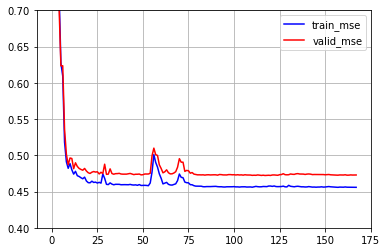

In [160]:
# plot losses
# plt.plot(clf.history['loss'])
plt.plot(clf.history['train_mse'],'b')
plt.plot(clf.history['valid_mse'],'r')
plt.legend(['train_mse','valid_mse'])
plt.grid(True)
plt.gca().set_ylim(0.4, 0.7) 
plt.show()

In [ ]:
plt.plot(clf.history['X_train']['loss'],'b')
plt.plot(clf.history['X_valid']['loss'],'r')

In [ ]:
plt.plot(clf.history['lr'])

In [ ]:
plt.plot(clf.history['lr'])

In [161]:
preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE  : {clf.best_cost}")
print(f"FINAL TEST SCORE  : {test_score}")

BEST VALID SCORE  : 0.4721820479649035
FINAL TEST SCORE  : 0.4648419391728419


In [ ]:
import itertools

n_d = [16,32,64]
n_independent = [2,3,4]
n_steps = [2,5,3]

c = list(itertools.product(n_d, n_independent,n_steps))
type((c[0][1]))

In [10]:
batch_size = 16384
max_epochs = 1000 

In [21]:
import itertools

n_d = [32]
n_independent = [4]
n_steps = [4]
lr = [2e-2,2e-3,2e-4]
gamma = [0.98,0.99,0.97,0.96,0.95]

# n_d = [32,64,128]
# n_independent = [2,2,2]
# n_steps = [2,2,2]
c = list(itertools.product(n_d, n_independent,n_steps,lr,gamma))
cc = len(c)
best__score = []
best_score_test = []

for i in range (len(c)):
    clf = TabNetRegressor(n_d = c[i][0], n_a = c[i][0] , n_independent = c[i][1], n_shared = c[i][1]
                          , n_steps=c[i][2] ,lambda_sparse = 1e-3,
    optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=c[i][3]),
                       scheduler_fn=torch.optim.lr_scheduler.ExponentialLR,
                       scheduler_params={"gamma":c[i][4] # max because default eval metric for binary is AUC
#                                          "factor":0.001,
#                                          "patience":10,
                                        },
                       mask_type='entmax', # "sparsemax",
                      )
    
    
    clf.fit(
    X_train=X_train, y_train=y_train.to_numpy().reshape(-1,1),
    eval_set=[(X_train, y_train.to_numpy().reshape(-1,1)), (X_valid, y_valid.to_numpy().reshape(-1,1))],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=batch_size, virtual_batch_size=256,
    num_workers=5,
    drop_last=False
            )
    
    
    
    
    preds = clf.predict(X_test)

    y_true = y_test

    test_score = mean_squared_error(y_pred=preds, y_true=y_true)

    print(f"BEST VALID SCORE  : {clf.best_cost}")
    print(f"FINAL TEST SCORE  : {test_score}")
    
    a = clf.best_cost
    b = test_score
    best__score.append(a)
    best_score_test.append(b)

Device used : cuda
epoch 0  | loss: 5.85459 | train_mse: 13.35137| valid_mse: 6.76626 |  0:00:02s
epoch 1  | loss: 2.23035 | train_mse: 5.68706 | valid_mse: 5.2643  |  0:00:04s
epoch 2  | loss: 1.47303 | train_mse: 54.40446| valid_mse: 1.09446 |  0:00:07s
epoch 3  | loss: 1.00685 | train_mse: 1.37811 | valid_mse: 0.84388 |  0:00:09s
epoch 4  | loss: 0.95408 | train_mse: 0.64502 | valid_mse: 0.78584 |  0:00:12s
epoch 5  | loss: 0.81893 | train_mse: 0.65135 | valid_mse: 0.71109 |  0:00:14s
epoch 6  | loss: 0.72347 | train_mse: 0.60085 | valid_mse: 0.76669 |  0:00:17s
epoch 7  | loss: 0.66424 | train_mse: 0.56568 | valid_mse: 0.5751  |  0:00:19s
epoch 8  | loss: 0.58187 | train_mse: 0.57584 | valid_mse: 0.59235 |  0:00:21s
epoch 9  | loss: 0.5779  | train_mse: 0.49139 | valid_mse: 0.50749 |  0:00:24s
epoch 10 | loss: 0.52793 | train_mse: 0.49927 | valid_mse: 0.51314 |  0:00:26s
epoch 11 | loss: 0.5073  | train_mse: 0.49045 | valid_mse: 0.50428 |  0:00:29s
epoch 12 | loss: 0.49491 | train_

epoch 104| loss: 0.45682 | train_mse: 0.45452 | valid_mse: 0.47339 |  0:04:16s
epoch 105| loss: 0.45731 | train_mse: 0.45432 | valid_mse: 0.47299 |  0:04:18s
epoch 106| loss: 0.45713 | train_mse: 0.45425 | valid_mse: 0.47327 |  0:04:21s
epoch 107| loss: 0.45699 | train_mse: 0.45447 | valid_mse: 0.47304 |  0:04:23s
epoch 108| loss: 0.45729 | train_mse: 0.45437 | valid_mse: 0.47269 |  0:04:26s
epoch 109| loss: 0.45708 | train_mse: 0.45423 | valid_mse: 0.4732  |  0:04:28s
epoch 110| loss: 0.45651 | train_mse: 0.45421 | valid_mse: 0.4732  |  0:04:31s
epoch 111| loss: 0.45637 | train_mse: 0.4541  | valid_mse: 0.47331 |  0:04:33s
epoch 112| loss: 0.45677 | train_mse: 0.45395 | valid_mse: 0.47321 |  0:04:36s
epoch 113| loss: 0.45659 | train_mse: 0.45389 | valid_mse: 0.47271 |  0:04:38s
epoch 114| loss: 0.4567  | train_mse: 0.45408 | valid_mse: 0.47259 |  0:04:41s
epoch 115| loss: 0.45683 | train_mse: 0.45384 | valid_mse: 0.47292 |  0:04:43s
epoch 116| loss: 0.45654 | train_mse: 0.45381 | vali

epoch 22 | loss: 0.46506 | train_mse: 0.46227 | valid_mse: 0.47711 |  0:00:57s
epoch 23 | loss: 0.46329 | train_mse: 0.46145 | valid_mse: 0.47615 |  0:01:00s
epoch 24 | loss: 0.46359 | train_mse: 0.46105 | valid_mse: 0.47628 |  0:01:02s
epoch 25 | loss: 0.46423 | train_mse: 0.46136 | valid_mse: 0.47605 |  0:01:05s
epoch 26 | loss: 0.46286 | train_mse: 0.46007 | valid_mse: 0.47624 |  0:01:07s
epoch 27 | loss: 0.46379 | train_mse: 0.46044 | valid_mse: 0.47699 |  0:01:10s
epoch 28 | loss: 0.46355 | train_mse: 0.4605  | valid_mse: 0.47746 |  0:01:12s
epoch 29 | loss: 0.46263 | train_mse: 0.46011 | valid_mse: 0.47546 |  0:01:15s
epoch 30 | loss: 0.46236 | train_mse: 0.45958 | valid_mse: 0.47571 |  0:01:17s
epoch 31 | loss: 0.46263 | train_mse: 0.46026 | valid_mse: 0.47626 |  0:01:20s
epoch 32 | loss: 0.46095 | train_mse: 0.45971 | valid_mse: 0.47658 |  0:01:23s
epoch 33 | loss: 0.4611  | train_mse: 0.45862 | valid_mse: 0.47549 |  0:01:25s
epoch 34 | loss: 0.46132 | train_mse: 0.45886 | vali

epoch 14 | loss: 0.47459 | train_mse: 0.46579 | valid_mse: 0.47944 |  0:00:37s
epoch 15 | loss: 0.4723  | train_mse: 0.46602 | valid_mse: 0.48096 |  0:00:40s
epoch 16 | loss: 0.47211 | train_mse: 0.46515 | valid_mse: 0.47984 |  0:00:42s
epoch 17 | loss: 0.46826 | train_mse: 0.46392 | valid_mse: 0.47727 |  0:00:45s
epoch 18 | loss: 0.46943 | train_mse: 0.46429 | valid_mse: 0.47837 |  0:00:48s
epoch 19 | loss: 0.46772 | train_mse: 0.46461 | valid_mse: 0.47916 |  0:00:50s
epoch 20 | loss: 0.46771 | train_mse: 0.46301 | valid_mse: 0.47803 |  0:00:53s
epoch 21 | loss: 0.46628 | train_mse: 0.4622  | valid_mse: 0.47637 |  0:00:55s
epoch 22 | loss: 0.46596 | train_mse: 0.46132 | valid_mse: 0.47603 |  0:00:58s
epoch 23 | loss: 0.4649  | train_mse: 0.46081 | valid_mse: 0.47498 |  0:01:00s
epoch 24 | loss: 0.46293 | train_mse: 0.46092 | valid_mse: 0.47592 |  0:01:03s
epoch 25 | loss: 0.46276 | train_mse: 0.46072 | valid_mse: 0.47492 |  0:01:05s
epoch 26 | loss: 0.462   | train_mse: 0.46056 | vali

epoch 118| loss: 0.45742 | train_mse: 0.45398 | valid_mse: 0.47418 |  0:05:00s
epoch 119| loss: 0.45652 | train_mse: 0.45396 | valid_mse: 0.47405 |  0:05:03s
epoch 120| loss: 0.45637 | train_mse: 0.45381 | valid_mse: 0.47427 |  0:05:05s
epoch 121| loss: 0.45705 | train_mse: 0.45398 | valid_mse: 0.47418 |  0:05:08s
epoch 122| loss: 0.45684 | train_mse: 0.45387 | valid_mse: 0.47424 |  0:05:10s
epoch 123| loss: 0.45652 | train_mse: 0.45395 | valid_mse: 0.47407 |  0:05:13s
epoch 124| loss: 0.4566  | train_mse: 0.45387 | valid_mse: 0.47413 |  0:05:15s
epoch 125| loss: 0.4568  | train_mse: 0.45391 | valid_mse: 0.47443 |  0:05:18s

Early stopping occured at epoch 125 with best_epoch = 75 and best_valid_mse = 0.47264
Best weights from best epoch are automatically used!
BEST VALID SCORE  : 0.47263715827016517
FINAL TEST SCORE  : 0.46382099078272654
Device used : cuda
epoch 0  | loss: 5.85459 | train_mse: 13.35137| valid_mse: 6.76626 |  0:00:02s
epoch 1  | loss: 1.99866 | train_mse: 2.66465 | va

epoch 93 | loss: 0.45736 | train_mse: 0.45474 | valid_mse: 0.47347 |  0:03:22s
epoch 94 | loss: 0.45714 | train_mse: 0.4546  | valid_mse: 0.47383 |  0:03:24s
epoch 95 | loss: 0.45769 | train_mse: 0.45454 | valid_mse: 0.47375 |  0:03:26s
epoch 96 | loss: 0.45693 | train_mse: 0.45475 | valid_mse: 0.47384 |  0:03:29s
epoch 97 | loss: 0.45761 | train_mse: 0.45457 | valid_mse: 0.47403 |  0:03:31s
epoch 98 | loss: 0.45757 | train_mse: 0.45454 | valid_mse: 0.4732  |  0:03:33s
epoch 99 | loss: 0.45791 | train_mse: 0.45438 | valid_mse: 0.4738  |  0:03:35s
epoch 100| loss: 0.45715 | train_mse: 0.45451 | valid_mse: 0.47377 |  0:03:37s
epoch 101| loss: 0.45718 | train_mse: 0.45446 | valid_mse: 0.47358 |  0:03:40s
epoch 102| loss: 0.45723 | train_mse: 0.45452 | valid_mse: 0.47361 |  0:03:42s
epoch 103| loss: 0.45757 | train_mse: 0.45451 | valid_mse: 0.47369 |  0:03:44s
epoch 104| loss: 0.4567  | train_mse: 0.45438 | valid_mse: 0.47376 |  0:03:46s
epoch 105| loss: 0.45715 | train_mse: 0.4544  | vali

epoch 45 | loss: 0.46022 | train_mse: 0.63484 | valid_mse: 0.48054 |  0:01:46s
epoch 46 | loss: 0.45998 | train_mse: 0.57348 | valid_mse: 0.47711 |  0:01:49s
epoch 47 | loss: 0.45922 | train_mse: 0.68272 | valid_mse: 0.48182 |  0:01:51s
epoch 48 | loss: 0.45976 | train_mse: 0.7276  | valid_mse: 0.48091 |  0:01:53s
epoch 49 | loss: 0.4596  | train_mse: 0.61384 | valid_mse: 0.48329 |  0:01:56s
epoch 50 | loss: 0.45947 | train_mse: 0.68385 | valid_mse: 0.47967 |  0:01:58s
epoch 51 | loss: 0.45938 | train_mse: 0.99198 | valid_mse: 0.48125 |  0:02:00s
epoch 52 | loss: 0.45932 | train_mse: 0.97812 | valid_mse: 0.48132 |  0:02:03s
epoch 53 | loss: 0.45938 | train_mse: 0.73603 | valid_mse: 0.47836 |  0:02:05s
epoch 54 | loss: 0.45949 | train_mse: 0.57272 | valid_mse: 0.4762  |  0:02:07s
epoch 55 | loss: 0.45975 | train_mse: 0.45703 | valid_mse: 0.47929 |  0:02:10s
epoch 56 | loss: 0.4593  | train_mse: 0.93886 | valid_mse: 0.48356 |  0:02:12s
epoch 57 | loss: 0.45887 | train_mse: 0.73015 | vali

epoch 66 | loss: 0.60109 | train_mse: 1.54641 | valid_mse: 2.74707 |  0:02:40s
epoch 67 | loss: 0.59433 | train_mse: 4.82261 | valid_mse: 0.77729 |  0:02:42s
epoch 68 | loss: 0.59455 | train_mse: 0.65128 | valid_mse: 0.55101 |  0:02:44s
epoch 69 | loss: 0.60772 | train_mse: 0.71687 | valid_mse: 0.704   |  0:02:47s
epoch 70 | loss: 0.58452 | train_mse: 0.88669 | valid_mse: 1.51197 |  0:02:49s
epoch 71 | loss: 0.58239 | train_mse: 1.03688 | valid_mse: 0.72947 |  0:02:51s
epoch 72 | loss: 0.57935 | train_mse: 0.55771 | valid_mse: 0.56125 |  0:02:54s
epoch 73 | loss: 0.58449 | train_mse: 0.56661 | valid_mse: 0.5733  |  0:02:56s
epoch 74 | loss: 0.57688 | train_mse: 0.59699 | valid_mse: 0.58223 |  0:02:58s
epoch 75 | loss: 0.58007 | train_mse: 0.62784 | valid_mse: 0.55745 |  0:03:01s
epoch 76 | loss: 0.57303 | train_mse: 0.53801 | valid_mse: 0.53547 |  0:03:03s
epoch 77 | loss: 0.56925 | train_mse: 0.55753 | valid_mse: 0.64039 |  0:03:06s
epoch 78 | loss: 0.568   | train_mse: 0.62324 | vali

epoch 170| loss: 0.55453 | train_mse: 0.53295 | valid_mse: 0.5394  |  0:06:50s
epoch 171| loss: 0.55585 | train_mse: 0.52292 | valid_mse: 0.5326  |  0:06:53s
epoch 172| loss: 0.56028 | train_mse: 0.56243 | valid_mse: 0.54417 |  0:06:55s
epoch 173| loss: 0.56125 | train_mse: 0.57359 | valid_mse: 0.57896 |  0:06:58s
epoch 174| loss: 0.55926 | train_mse: 0.53907 | valid_mse: 0.52039 |  0:07:00s
epoch 175| loss: 0.55033 | train_mse: 0.55162 | valid_mse: 0.53827 |  0:07:03s
epoch 176| loss: 0.56066 | train_mse: 0.55151 | valid_mse: 0.52762 |  0:07:06s
epoch 177| loss: 0.5611  | train_mse: 0.54942 | valid_mse: 0.53925 |  0:07:08s
epoch 178| loss: 0.55811 | train_mse: 0.59456 | valid_mse: 0.56608 |  0:07:11s
epoch 179| loss: 0.55985 | train_mse: 0.55525 | valid_mse: 0.54478 |  0:07:13s
epoch 180| loss: 0.55436 | train_mse: 0.61419 | valid_mse: 0.67022 |  0:07:16s
epoch 181| loss: 0.56571 | train_mse: 0.57367 | valid_mse: 0.53423 |  0:07:19s
epoch 182| loss: 0.5596  | train_mse: 0.54416 | vali

epoch 9  | loss: 1.84701 | train_mse: 1.3661  | valid_mse: 1.52506 |  0:00:24s
epoch 10 | loss: 1.73633 | train_mse: 1.58015 | valid_mse: 1.29212 |  0:00:26s
epoch 11 | loss: 1.5224  | train_mse: 3.87963 | valid_mse: 1.10385 |  0:00:29s
epoch 12 | loss: 1.55162 | train_mse: 1.71733 | valid_mse: 0.98091 |  0:00:31s
epoch 13 | loss: 1.3505  | train_mse: 0.92734 | valid_mse: 0.85447 |  0:00:34s
epoch 14 | loss: 1.32146 | train_mse: 3.31014 | valid_mse: 1.24802 |  0:00:36s
epoch 15 | loss: 1.1985  | train_mse: 31.82389| valid_mse: 0.90645 |  0:00:39s
epoch 16 | loss: 1.15559 | train_mse: 0.82347 | valid_mse: 0.82683 |  0:00:41s
epoch 17 | loss: 1.1465  | train_mse: 0.91158 | valid_mse: 0.88657 |  0:00:44s
epoch 18 | loss: 1.08324 | train_mse: 1.08399 | valid_mse: 1.08378 |  0:00:46s
epoch 19 | loss: 1.04513 | train_mse: 0.89236 | valid_mse: 0.91942 |  0:00:49s
epoch 20 | loss: 1.02855 | train_mse: 3.57281 | valid_mse: 1.3588  |  0:00:51s
epoch 21 | loss: 1.05755 | train_mse: 0.90713 | vali

epoch 113| loss: 0.49921 | train_mse: 0.49278 | valid_mse: 0.50708 |  0:04:37s
epoch 114| loss: 0.50249 | train_mse: 0.4974  | valid_mse: 0.51585 |  0:04:39s
epoch 115| loss: 0.49821 | train_mse: 0.49964 | valid_mse: 0.51428 |  0:04:42s
epoch 116| loss: 0.49774 | train_mse: 0.48865 | valid_mse: 0.50334 |  0:04:44s
epoch 117| loss: 0.49696 | train_mse: 0.49088 | valid_mse: 0.50734 |  0:04:47s
epoch 118| loss: 0.49677 | train_mse: 0.48621 | valid_mse: 0.50522 |  0:04:49s
epoch 119| loss: 0.49133 | train_mse: 0.48785 | valid_mse: 0.50348 |  0:04:52s
epoch 120| loss: 0.48939 | train_mse: 0.49238 | valid_mse: 0.50341 |  0:04:54s
epoch 121| loss: 0.49323 | train_mse: 0.49237 | valid_mse: 0.50479 |  0:04:57s
epoch 122| loss: 0.49321 | train_mse: 0.48859 | valid_mse: 0.505   |  0:04:59s
epoch 123| loss: 0.49272 | train_mse: 0.48171 | valid_mse: 0.49596 |  0:05:02s
epoch 124| loss: 0.49092 | train_mse: 0.48302 | valid_mse: 0.50008 |  0:05:04s
epoch 125| loss: 0.49185 | train_mse: 0.48555 | vali

epoch 217| loss: 0.47508 | train_mse: 0.46893 | valid_mse: 0.48837 |  0:08:47s
epoch 218| loss: 0.4755  | train_mse: 0.46799 | valid_mse: 0.48479 |  0:08:50s
epoch 219| loss: 0.47739 | train_mse: 0.46712 | valid_mse: 0.48541 |  0:08:52s
epoch 220| loss: 0.47763 | train_mse: 0.47003 | valid_mse: 0.48922 |  0:08:54s
epoch 221| loss: 0.4756  | train_mse: 0.46543 | valid_mse: 0.48442 |  0:08:57s
epoch 222| loss: 0.47717 | train_mse: 0.46986 | valid_mse: 0.48603 |  0:08:59s
epoch 223| loss: 0.47624 | train_mse: 0.46545 | valid_mse: 0.48483 |  0:09:02s
epoch 224| loss: 0.47509 | train_mse: 0.46711 | valid_mse: 0.4859  |  0:09:04s
epoch 225| loss: 0.47764 | train_mse: 0.47121 | valid_mse: 0.48585 |  0:09:06s
epoch 226| loss: 0.47554 | train_mse: 0.46738 | valid_mse: 0.48357 |  0:09:09s
epoch 227| loss: 0.47556 | train_mse: 0.46717 | valid_mse: 0.48349 |  0:09:11s
epoch 228| loss: 0.47714 | train_mse: 0.46622 | valid_mse: 0.48199 |  0:09:14s
epoch 229| loss: 0.47627 | train_mse: 0.46685 | vali

BEST VALID SCORE  : 0.48003879698164703
FINAL TEST SCORE  : 0.47150336489789996
Device used : cuda
epoch 0  | loss: 8.79315 | train_mse: 48.30352| valid_mse: 7.14169 |  0:00:02s
epoch 1  | loss: 6.81815 | train_mse: 7.44216 | valid_mse: 7.02172 |  0:00:04s
epoch 2  | loss: 5.57412 | train_mse: 24.25918| valid_mse: 6.40869 |  0:00:07s
epoch 3  | loss: 4.48577 | train_mse: 33.43492| valid_mse: 5.07569 |  0:00:09s
epoch 4  | loss: 3.60072 | train_mse: 3.50267 | valid_mse: 3.01102 |  0:00:12s
epoch 5  | loss: 2.93015 | train_mse: 3.39928 | valid_mse: 3.15993 |  0:00:14s
epoch 6  | loss: 2.56246 | train_mse: 3.29789 | valid_mse: 3.45399 |  0:00:17s
epoch 7  | loss: 2.10788 | train_mse: 3.84605 | valid_mse: 4.0218  |  0:00:19s
epoch 8  | loss: 1.92716 | train_mse: 2.76734 | valid_mse: 2.66821 |  0:00:21s
epoch 9  | loss: 1.71873 | train_mse: 2.42453 | valid_mse: 2.14675 |  0:00:24s
epoch 10 | loss: 1.68222 | train_mse: 2.48746 | valid_mse: 2.1867  |  0:00:26s
epoch 11 | loss: 1.57154 | train

epoch 103| loss: 0.62189 | train_mse: 0.56172 | valid_mse: 0.65923 |  0:04:09s
epoch 104| loss: 0.61057 | train_mse: 0.55761 | valid_mse: 0.66982 |  0:04:11s
epoch 105| loss: 0.62058 | train_mse: 0.5656  | valid_mse: 0.65019 |  0:04:14s
epoch 106| loss: 0.61252 | train_mse: 0.54586 | valid_mse: 0.62406 |  0:04:16s
epoch 107| loss: 0.61226 | train_mse: 0.59016 | valid_mse: 0.69369 |  0:04:19s
epoch 108| loss: 0.61778 | train_mse: 0.55338 | valid_mse: 0.6214  |  0:04:21s
epoch 109| loss: 0.61623 | train_mse: 0.57654 | valid_mse: 0.65764 |  0:04:24s
epoch 110| loss: 0.61996 | train_mse: 0.54848 | valid_mse: 0.5935  |  0:04:26s
epoch 111| loss: 0.61139 | train_mse: 0.58472 | valid_mse: 0.68742 |  0:04:29s
epoch 112| loss: 0.61315 | train_mse: 0.55584 | valid_mse: 0.60333 |  0:04:31s
epoch 113| loss: 0.61255 | train_mse: 0.57064 | valid_mse: 0.65205 |  0:04:33s
epoch 114| loss: 0.61105 | train_mse: 0.62954 | valid_mse: 0.62396 |  0:04:36s
epoch 115| loss: 0.61141 | train_mse: 0.56341 | vali

epoch 14 | loss: 1.37122 | train_mse: 1.04234 | valid_mse: 0.83385 |  0:00:36s
epoch 15 | loss: 1.30298 | train_mse: 0.88599 | valid_mse: 0.83966 |  0:00:38s
epoch 16 | loss: 1.29173 | train_mse: 0.90696 | valid_mse: 0.81914 |  0:00:41s
epoch 17 | loss: 1.29325 | train_mse: 1.34698 | valid_mse: 0.82164 |  0:00:43s
epoch 18 | loss: 1.19895 | train_mse: 1.06151 | valid_mse: 0.96758 |  0:00:46s
epoch 19 | loss: 1.17308 | train_mse: 3.02761 | valid_mse: 0.8614  |  0:00:48s
epoch 20 | loss: 1.13053 | train_mse: 1.59539 | valid_mse: 1.11079 |  0:00:50s
epoch 21 | loss: 1.1073  | train_mse: 6.0428  | valid_mse: 1.11985 |  0:00:53s
epoch 22 | loss: 1.09104 | train_mse: 1.18708 | valid_mse: 1.09059 |  0:00:55s
epoch 23 | loss: 1.09956 | train_mse: 1.24422 | valid_mse: 1.11274 |  0:00:58s
epoch 24 | loss: 1.02462 | train_mse: 1.82101 | valid_mse: 1.09419 |  0:01:00s
epoch 25 | loss: 1.03443 | train_mse: 2.24655 | valid_mse: 0.97072 |  0:01:02s
epoch 26 | loss: 1.03986 | train_mse: 1.20535 | vali

epoch 118| loss: 0.79136 | train_mse: 0.60968 | valid_mse: 0.60014 |  0:04:47s
epoch 119| loss: 0.80265 | train_mse: 0.68573 | valid_mse: 0.60869 |  0:04:49s
epoch 120| loss: 0.7744  | train_mse: 0.64414 | valid_mse: 0.63172 |  0:04:52s
epoch 121| loss: 0.78813 | train_mse: 0.71618 | valid_mse: 0.62391 |  0:04:54s
epoch 122| loss: 0.78773 | train_mse: 0.62832 | valid_mse: 0.60858 |  0:04:56s
epoch 123| loss: 0.78472 | train_mse: 0.62522 | valid_mse: 0.60594 |  0:04:59s
epoch 124| loss: 0.77405 | train_mse: 0.62571 | valid_mse: 0.6162  |  0:05:01s
epoch 125| loss: 0.79061 | train_mse: 0.61636 | valid_mse: 0.60787 |  0:05:04s
epoch 126| loss: 0.79206 | train_mse: 0.62982 | valid_mse: 0.61954 |  0:05:06s
epoch 127| loss: 0.77776 | train_mse: 0.639   | valid_mse: 0.61819 |  0:05:08s
epoch 128| loss: 0.76624 | train_mse: 0.66332 | valid_mse: 0.62116 |  0:05:11s
epoch 129| loss: 0.78512 | train_mse: 0.66236 | valid_mse: 0.6174  |  0:05:13s
epoch 130| loss: 0.78975 | train_mse: 1.29096 | vali

epoch 83 | loss: 0.87966 | train_mse: 0.67449 | valid_mse: 0.67694 |  0:03:00s
epoch 84 | loss: 0.90666 | train_mse: 0.85084 | valid_mse: 0.68254 |  0:03:02s
epoch 85 | loss: 0.88776 | train_mse: 0.81924 | valid_mse: 0.70264 |  0:03:04s
epoch 86 | loss: 0.87043 | train_mse: 0.76808 | valid_mse: 0.7067  |  0:03:06s
epoch 87 | loss: 0.88525 | train_mse: 0.66755 | valid_mse: 0.70086 |  0:03:08s
epoch 88 | loss: 0.88764 | train_mse: 0.67551 | valid_mse: 0.67894 |  0:03:10s
epoch 89 | loss: 0.86826 | train_mse: 0.66033 | valid_mse: 0.68832 |  0:03:13s
epoch 90 | loss: 0.86308 | train_mse: 0.71322 | valid_mse: 0.7387  |  0:03:15s
epoch 91 | loss: 0.88794 | train_mse: 0.73131 | valid_mse: 0.69286 |  0:03:17s
epoch 92 | loss: 0.91109 | train_mse: 0.78489 | valid_mse: 0.68222 |  0:03:19s
epoch 93 | loss: 0.86172 | train_mse: 0.65856 | valid_mse: 0.64208 |  0:03:21s
epoch 94 | loss: 0.88324 | train_mse: 0.68281 | valid_mse: 0.68453 |  0:03:24s
epoch 95 | loss: 0.88843 | train_mse: 0.66586 | vali

epoch 40 | loss: 4.91823 | train_mse: 9.77892 | valid_mse: 4.59253 |  0:01:37s
epoch 41 | loss: 4.897   | train_mse: 9.51653 | valid_mse: 4.72478 |  0:01:40s
epoch 42 | loss: 4.80914 | train_mse: 12.29711| valid_mse: 4.55837 |  0:01:42s
epoch 43 | loss: 4.80065 | train_mse: 7.44524 | valid_mse: 4.44745 |  0:01:44s
epoch 44 | loss: 4.77014 | train_mse: 9.71354 | valid_mse: 4.26271 |  0:01:47s
epoch 45 | loss: 4.74647 | train_mse: 4.4296  | valid_mse: 4.3623  |  0:01:49s
epoch 46 | loss: 4.66367 | train_mse: 4.74191 | valid_mse: 3.84064 |  0:01:52s
epoch 47 | loss: 4.68309 | train_mse: 11.04201| valid_mse: 4.28375 |  0:01:54s
epoch 48 | loss: 4.58278 | train_mse: 3.86981 | valid_mse: 3.74423 |  0:01:56s
epoch 49 | loss: 4.63711 | train_mse: 4.35662 | valid_mse: 3.94961 |  0:01:59s
epoch 50 | loss: 4.53399 | train_mse: 4.72607 | valid_mse: 3.93063 |  0:02:01s
epoch 51 | loss: 4.48987 | train_mse: 6.76684 | valid_mse: 3.80452 |  0:02:03s
epoch 52 | loss: 4.54613 | train_mse: 4.17061 | vali

epoch 144| loss: 3.36439 | train_mse: 2.88871 | valid_mse: 2.85753 |  0:05:49s
epoch 145| loss: 3.3054  | train_mse: 3.0644  | valid_mse: 2.80084 |  0:05:51s
epoch 146| loss: 3.2975  | train_mse: 2.95126 | valid_mse: 2.86609 |  0:05:54s
epoch 147| loss: 3.27644 | train_mse: 2.7981  | valid_mse: 2.76582 |  0:05:56s
epoch 148| loss: 3.35703 | train_mse: 2.92836 | valid_mse: 2.70003 |  0:05:59s
epoch 149| loss: 3.35839 | train_mse: 2.84265 | valid_mse: 2.97705 |  0:06:01s
epoch 150| loss: 3.26713 | train_mse: 3.0034  | valid_mse: 3.14508 |  0:06:03s
epoch 151| loss: 3.25496 | train_mse: 2.84606 | valid_mse: 2.80955 |  0:06:06s
epoch 152| loss: 3.26403 | train_mse: 2.7974  | valid_mse: 2.96605 |  0:06:08s
epoch 153| loss: 3.31044 | train_mse: 2.95222 | valid_mse: 2.82578 |  0:06:11s
epoch 154| loss: 3.34867 | train_mse: 2.80908 | valid_mse: 2.91631 |  0:06:13s
epoch 155| loss: 3.27484 | train_mse: 2.96019 | valid_mse: 3.1818  |  0:06:15s
epoch 156| loss: 3.26734 | train_mse: 2.72111 | vali

epoch 248| loss: 3.1798  | train_mse: 2.80174 | valid_mse: 2.82233 |  0:09:57s
epoch 249| loss: 3.18883 | train_mse: 2.81409 | valid_mse: 2.69753 |  0:09:59s
epoch 250| loss: 3.19603 | train_mse: 2.79839 | valid_mse: 2.67157 |  0:10:02s
epoch 251| loss: 3.20232 | train_mse: 2.94981 | valid_mse: 2.82337 |  0:10:04s
epoch 252| loss: 3.22889 | train_mse: 2.62773 | valid_mse: 2.77446 |  0:10:07s
epoch 253| loss: 3.22699 | train_mse: 2.74135 | valid_mse: 2.93411 |  0:10:10s
epoch 254| loss: 3.14534 | train_mse: 2.72133 | valid_mse: 2.63849 |  0:10:12s
epoch 255| loss: 3.20026 | train_mse: 2.6721  | valid_mse: 2.66989 |  0:10:15s
epoch 256| loss: 3.16742 | train_mse: 2.88202 | valid_mse: 2.66926 |  0:10:17s
epoch 257| loss: 3.24705 | train_mse: 2.8581  | valid_mse: 2.72094 |  0:10:20s
epoch 258| loss: 3.18231 | train_mse: 2.71253 | valid_mse: 2.76861 |  0:10:22s
epoch 259| loss: 3.26386 | train_mse: 2.78871 | valid_mse: 2.68404 |  0:10:25s
epoch 260| loss: 3.19136 | train_mse: 2.62251 | vali

epoch 5  | loss: 8.11266 | train_mse: 13.50133| valid_mse: 8.56297 |  0:00:14s
epoch 6  | loss: 7.95843 | train_mse: 6.98252 | valid_mse: 6.97132 |  0:00:17s
epoch 7  | loss: 7.89873 | train_mse: 8.71923 | valid_mse: 7.75225 |  0:00:19s
epoch 8  | loss: 7.56954 | train_mse: 47.4009 | valid_mse: 7.01907 |  0:00:22s
epoch 9  | loss: 7.39704 | train_mse: 6.69864 | valid_mse: 6.56018 |  0:00:24s
epoch 10 | loss: 7.29694 | train_mse: 10.67122| valid_mse: 6.61079 |  0:00:27s
epoch 11 | loss: 7.14237 | train_mse: 12.799  | valid_mse: 7.1676  |  0:00:29s
epoch 12 | loss: 6.99868 | train_mse: 6.55857 | valid_mse: 5.95522 |  0:00:32s
epoch 13 | loss: 6.84184 | train_mse: 6.59876 | valid_mse: 6.29223 |  0:00:34s
epoch 14 | loss: 6.75564 | train_mse: 7.87671 | valid_mse: 7.33041 |  0:00:37s
epoch 15 | loss: 6.66036 | train_mse: 23.52412| valid_mse: 6.3141  |  0:00:39s
epoch 16 | loss: 6.47249 | train_mse: 6.73623 | valid_mse: 6.1874  |  0:00:42s
epoch 17 | loss: 6.39283 | train_mse: 5.7491  | vali

epoch 109| loss: 2.68535 | train_mse: 2.29922 | valid_mse: 2.4609  |  0:04:29s
epoch 110| loss: 2.68525 | train_mse: 2.80398 | valid_mse: 2.49257 |  0:04:32s
epoch 111| loss: 2.6407  | train_mse: 2.48165 | valid_mse: 2.20713 |  0:04:34s
epoch 112| loss: 2.64228 | train_mse: 2.44956 | valid_mse: 2.6093  |  0:04:37s
epoch 113| loss: 2.60803 | train_mse: 2.18825 | valid_mse: 2.22498 |  0:04:39s
epoch 114| loss: 2.6155  | train_mse: 2.85221 | valid_mse: 2.87941 |  0:04:42s
epoch 115| loss: 2.609   | train_mse: 2.41996 | valid_mse: 2.30186 |  0:04:44s
epoch 116| loss: 2.60326 | train_mse: 2.56816 | valid_mse: 2.58766 |  0:04:46s
epoch 117| loss: 2.56898 | train_mse: 2.31078 | valid_mse: 2.14774 |  0:04:49s
epoch 118| loss: 2.56565 | train_mse: 2.57817 | valid_mse: 2.72953 |  0:04:51s
epoch 119| loss: 2.63608 | train_mse: 2.16532 | valid_mse: 2.18944 |  0:04:54s
epoch 120| loss: 2.56748 | train_mse: 2.11286 | valid_mse: 2.20393 |  0:04:56s
epoch 121| loss: 2.59041 | train_mse: 2.32346 | vali

epoch 213| loss: 1.98705 | train_mse: 1.84544 | valid_mse: 1.76026 |  0:08:40s
epoch 214| loss: 2.03245 | train_mse: 1.69763 | valid_mse: 1.72805 |  0:08:42s
epoch 215| loss: 2.03324 | train_mse: 1.759   | valid_mse: 1.77908 |  0:08:44s
epoch 216| loss: 1.9726  | train_mse: 1.83389 | valid_mse: 1.79732 |  0:08:47s
epoch 217| loss: 2.01693 | train_mse: 1.69522 | valid_mse: 1.66275 |  0:08:49s
epoch 218| loss: 2.02596 | train_mse: 1.88182 | valid_mse: 1.79043 |  0:08:52s
epoch 219| loss: 2.07767 | train_mse: 1.66465 | valid_mse: 1.62354 |  0:08:54s
epoch 220| loss: 1.99542 | train_mse: 2.13606 | valid_mse: 1.82951 |  0:08:56s
epoch 221| loss: 1.96021 | train_mse: 1.9173  | valid_mse: 1.71098 |  0:08:59s
epoch 222| loss: 2.04262 | train_mse: 1.63434 | valid_mse: 1.61561 |  0:09:01s
epoch 223| loss: 2.00502 | train_mse: 1.69657 | valid_mse: 1.67769 |  0:09:03s
epoch 224| loss: 2.00243 | train_mse: 1.72197 | valid_mse: 1.69987 |  0:09:06s
epoch 225| loss: 1.9939  | train_mse: 1.73579 | vali

epoch 317| loss: 1.87041 | train_mse: 1.67585 | valid_mse: 1.62491 |  0:12:49s
epoch 318| loss: 1.84519 | train_mse: 1.65901 | valid_mse: 1.66398 |  0:12:51s
epoch 319| loss: 1.86095 | train_mse: 1.89796 | valid_mse: 1.68003 |  0:12:54s
epoch 320| loss: 1.9015  | train_mse: 1.53623 | valid_mse: 1.59525 |  0:12:56s
epoch 321| loss: 1.84496 | train_mse: 2.00541 | valid_mse: 2.04034 |  0:12:59s
epoch 322| loss: 1.87096 | train_mse: 1.60486 | valid_mse: 1.63966 |  0:13:01s
epoch 323| loss: 1.92146 | train_mse: 1.45458 | valid_mse: 1.56017 |  0:13:03s
epoch 324| loss: 1.82333 | train_mse: 1.50189 | valid_mse: 1.48549 |  0:13:06s
epoch 325| loss: 1.88047 | train_mse: 1.64637 | valid_mse: 1.42661 |  0:13:08s
epoch 326| loss: 1.84612 | train_mse: 1.50483 | valid_mse: 1.5249  |  0:13:10s
epoch 327| loss: 1.89015 | train_mse: 1.70022 | valid_mse: 1.71484 |  0:13:13s
epoch 328| loss: 1.84911 | train_mse: 1.523   | valid_mse: 1.44053 |  0:13:15s
epoch 329| loss: 1.89297 | train_mse: 1.65348 | vali

epoch 81 | loss: 4.65506 | train_mse: 7.25311 | valid_mse: 3.93785 |  0:03:17s
epoch 82 | loss: 4.66969 | train_mse: 5.66902 | valid_mse: 4.08735 |  0:03:19s
epoch 83 | loss: 4.61335 | train_mse: 3.96381 | valid_mse: 3.74735 |  0:03:22s
epoch 84 | loss: 4.63788 | train_mse: 4.29247 | valid_mse: 4.05523 |  0:03:24s
epoch 85 | loss: 4.61789 | train_mse: 4.1893  | valid_mse: 4.02431 |  0:03:27s
epoch 86 | loss: 4.56198 | train_mse: 5.74461 | valid_mse: 3.93262 |  0:03:29s
epoch 87 | loss: 4.59272 | train_mse: 5.13324 | valid_mse: 3.85818 |  0:03:31s
epoch 88 | loss: 4.61148 | train_mse: 4.10828 | valid_mse: 3.99771 |  0:03:34s
epoch 89 | loss: 4.49569 | train_mse: 4.30462 | valid_mse: 4.02636 |  0:03:36s
epoch 90 | loss: 4.59257 | train_mse: 5.38211 | valid_mse: 3.75197 |  0:03:39s
epoch 91 | loss: 4.55803 | train_mse: 4.58347 | valid_mse: 4.24081 |  0:03:41s
epoch 92 | loss: 4.5338  | train_mse: 4.12349 | valid_mse: 3.94941 |  0:03:43s
epoch 93 | loss: 4.63611 | train_mse: 4.30709 | vali

epoch 10 | loss: 7.58373 | train_mse: 6.65358 | valid_mse: 6.42979 |  0:00:25s
epoch 11 | loss: 7.53943 | train_mse: 10.14889| valid_mse: 6.98058 |  0:00:27s
epoch 12 | loss: 7.33377 | train_mse: 18.047  | valid_mse: 6.40766 |  0:00:29s
epoch 13 | loss: 7.22836 | train_mse: 6.99108 | valid_mse: 6.99495 |  0:00:31s
epoch 14 | loss: 7.32007 | train_mse: 6.74115 | valid_mse: 6.48723 |  0:00:34s
epoch 15 | loss: 7.07162 | train_mse: 6.72615 | valid_mse: 6.41787 |  0:00:36s
epoch 16 | loss: 7.04476 | train_mse: 13.59053| valid_mse: 6.50361 |  0:00:38s
epoch 17 | loss: 6.89604 | train_mse: 6.09427 | valid_mse: 5.9892  |  0:00:40s
epoch 18 | loss: 6.88608 | train_mse: 8.33003 | valid_mse: 6.33423 |  0:00:42s
epoch 19 | loss: 6.7842  | train_mse: 6.27916 | valid_mse: 5.98221 |  0:00:44s
epoch 20 | loss: 6.7215  | train_mse: 5.88842 | valid_mse: 6.13676 |  0:00:46s
epoch 21 | loss: 6.7153  | train_mse: 6.19566 | valid_mse: 5.88474 |  0:00:49s
epoch 22 | loss: 6.74941 | train_mse: 10.99861| vali

epoch 114| loss: 5.44846 | train_mse: 5.18246 | valid_mse: 4.9557  |  0:04:08s
epoch 115| loss: 5.5221  | train_mse: 5.58204 | valid_mse: 5.22254 |  0:04:10s
epoch 116| loss: 5.48422 | train_mse: 5.28599 | valid_mse: 5.0224  |  0:04:12s
epoch 117| loss: 5.46875 | train_mse: 5.35417 | valid_mse: 5.04273 |  0:04:14s
epoch 118| loss: 5.48071 | train_mse: 5.77402 | valid_mse: 4.68956 |  0:04:16s
epoch 119| loss: 5.51697 | train_mse: 4.96321 | valid_mse: 4.85667 |  0:04:18s
epoch 120| loss: 5.52804 | train_mse: 5.05515 | valid_mse: 4.87455 |  0:04:21s
epoch 121| loss: 5.49473 | train_mse: 5.04558 | valid_mse: 4.91126 |  0:04:23s
epoch 122| loss: 5.39603 | train_mse: 5.30701 | valid_mse: 5.04695 |  0:04:25s
epoch 123| loss: 5.61599 | train_mse: 5.3787  | valid_mse: 4.90621 |  0:04:27s
epoch 124| loss: 5.5057  | train_mse: 5.41842 | valid_mse: 5.18491 |  0:04:29s
epoch 125| loss: 5.41164 | train_mse: 5.54058 | valid_mse: 5.12538 |  0:04:31s
epoch 126| loss: 5.50664 | train_mse: 5.35385 | vali

epoch 57 | loss: 6.09861 | train_mse: 6.35084 | valid_mse: 5.39328 |  0:02:11s
epoch 58 | loss: 6.13231 | train_mse: 5.27937 | valid_mse: 5.1426  |  0:02:13s
epoch 59 | loss: 6.09747 | train_mse: 5.11742 | valid_mse: 5.08266 |  0:02:15s
epoch 60 | loss: 6.04291 | train_mse: 5.11653 | valid_mse: 5.11923 |  0:02:18s
epoch 61 | loss: 6.12268 | train_mse: 5.24229 | valid_mse: 5.09822 |  0:02:20s
epoch 62 | loss: 6.07629 | train_mse: 5.31302 | valid_mse: 5.27181 |  0:02:22s
epoch 63 | loss: 6.0788  | train_mse: 5.39189 | valid_mse: 5.08079 |  0:02:25s
epoch 64 | loss: 6.15417 | train_mse: 5.51852 | valid_mse: 5.27266 |  0:02:27s
epoch 65 | loss: 6.07005 | train_mse: 5.58733 | valid_mse: 5.34549 |  0:02:29s
epoch 66 | loss: 6.02038 | train_mse: 5.09117 | valid_mse: 4.93668 |  0:02:32s
epoch 67 | loss: 5.9976  | train_mse: 5.39705 | valid_mse: 5.39996 |  0:02:34s
epoch 68 | loss: 6.0903  | train_mse: 5.43486 | valid_mse: 5.19589 |  0:02:36s
epoch 69 | loss: 6.04301 | train_mse: 5.17804 | vali

epoch 161| loss: 6.00815 | train_mse: 5.40382 | valid_mse: 5.13138 |  0:06:10s
epoch 162| loss: 5.98066 | train_mse: 5.45318 | valid_mse: 5.38678 |  0:06:13s
epoch 163| loss: 6.02367 | train_mse: 5.47325 | valid_mse: 5.3995  |  0:06:15s
epoch 164| loss: 5.98047 | train_mse: 5.0548  | valid_mse: 5.02792 |  0:06:17s
epoch 165| loss: 5.99179 | train_mse: 5.54495 | valid_mse: 5.37368 |  0:06:20s
epoch 166| loss: 5.94009 | train_mse: 5.52273 | valid_mse: 5.42702 |  0:06:22s
epoch 167| loss: 6.00513 | train_mse: 5.33922 | valid_mse: 5.31502 |  0:06:24s
epoch 168| loss: 5.95444 | train_mse: 5.53787 | valid_mse: 5.33879 |  0:06:27s
epoch 169| loss: 5.99679 | train_mse: 5.29452 | valid_mse: 5.18362 |  0:06:29s
epoch 170| loss: 5.97574 | train_mse: 6.60928 | valid_mse: 5.47508 |  0:06:31s
epoch 171| loss: 6.02899 | train_mse: 5.24844 | valid_mse: 5.3882  |  0:06:34s
epoch 172| loss: 6.00836 | train_mse: 5.46256 | valid_mse: 5.41949 |  0:06:36s
epoch 173| loss: 5.94563 | train_mse: 5.33737 | vali

In [22]:
print(best__score)
print("\n")
print(best_score_test)

[0.4720886483250728, 0.47481162940670907, 0.47263715827016517, 0.47320027057443215, 0.4743704092423725, 0.5142273189622255, 0.48003879698164703, 0.5792552653195882, 0.5937761906116326, 0.6420820295283735, 2.4726276977387958, 1.3999884703840109, 3.560229706720989, 4.595291974587213, 4.854757073741166]


[0.46536431726452754, 0.4657774467727341, 0.46382099078272654, 0.465553591049857, 0.4668736728054044, 0.513852404336647, 0.47150336489789996, 0.5157454280724955, 0.6052001954973856, 0.6785379971008614, 2.6216663810764307, 1.4315576431459713, 3.5860966356121797, 4.789459423073712, 4.847323078614354]


In [156]:
val, idx = min((val, idx) for (idx, val) in enumerate(best__score))

In [157]:
print('value is ', val, 'for idx', idx)

value is  0.4720886483250728 for idx 0


In [27]:
c[0]

(32, 4, 4, 0.02, 0.98)

In [11]:
in_trails = in_trails.drop_duplicates()

In [12]:
in_trails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 0 to 9799
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   zinc_id  9800 non-null   object
 1   smiles   9800 non-null   object
dtypes: object(2)
memory usage: 229.7+ KB


In [162]:
in_trails['mol'] = in_trails['smiles'].apply(Chem.MolFromSmiles)

In [163]:
in_trails = in_trails.dropna(subset=['mol'])
in_trails['HeavyAtomCount'] = in_trails['mol'].apply(Descriptors.HeavyAtomCount)
in_trails['HAccept'] = in_trails['mol'].apply(Descriptors.NumHAcceptors)
in_trails['HDonor'] = in_trails['mol'].apply(Descriptors.NumHDonors)
in_trails['Heteroatoms'] = in_trails['mol'].apply(Descriptors.NumHeteroatoms)
in_trails['RingCount'] = in_trails['mol'].apply(Descriptors.RingCount)
in_trails['SaturatedRings'] = in_trails['mol'].apply(Descriptors.NumSaturatedRings)
in_trails['AliphaticRings'] = in_trails['mol'].apply(Descriptors.NumAliphaticRings)
in_trails['AromaticRings'] = in_trails['mol'].apply(Descriptors.NumAromaticRings)
in_trails['Ipc'] = in_trails['mol'].apply(Descriptors.Ipc)
in_trails['HallKierAlpha'] = in_trails['mol'].apply(Descriptors.HallKierAlpha)
in_trails['NumValenceElectrons'] = in_trails['mol'].apply(Descriptors.NumValenceElectrons)
in_trails['MolLogP'] = in_trails['mol'].apply(Descriptors.MolLogP)
in_trails['AMW'] = in_trails['mol'].apply(Descriptors.MolWt)
in_trails['NumRotatableBonds'] = in_trails['mol'].apply(Descriptors.NumRotatableBonds)

In [164]:
X_in_trails = in_trails[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']]

In [165]:
in_trails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zinc_id              9800 non-null   object 
 1   smiles               9800 non-null   object 
 2   mol                  9800 non-null   object 
 3   HeavyAtomCount       9800 non-null   int64  
 4   HAccept              9800 non-null   int64  
 5   HDonor               9800 non-null   int64  
 6   Heteroatoms          9800 non-null   int64  
 7   RingCount            9800 non-null   int64  
 8   SaturatedRings       9800 non-null   int64  
 9   AliphaticRings       9800 non-null   int64  
 10  AromaticRings        9800 non-null   int64  
 11  Ipc                  9800 non-null   float64
 12  HallKierAlpha        9800 non-null   float64
 13  NumValenceElectrons  9800 non-null   int64  
 14  MolLogP              9800 non-null   float64
 15  AMW                  9800 non-null   f

In [166]:
X_in_trails[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']] = scaler_xtrain.transform(X_in_trails[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']])

/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/moazmohamed/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [167]:
X_in_trails['pred'] = clf.predict(X_in_trails.to_numpy())


/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [168]:
X_in_trails['smiles'] = in_trails['smiles']
# X_in_trails['smiles'] = np.log(X_in_trails['smiles'])

X_in_trails['zinc_id'] = in_trails['zinc_id']


/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [171]:
X_in_trails.sort_values("pred", ascending=False).head(15)

,MolLogP,AMW,NumRotatableBonds,HeavyAtomCount,HAccept,HDonor,Heteroatoms,RingCount,SaturatedRings,AliphaticRings,AromaticRings,Ipc,HallKierAlpha,NumValenceElectrons,pred,smiles,zinc_id
6876,12.650479,11.814498,9.000000,10.00,-0.5,-0.5,-1.5,-1.0,-1.0,0.0,-2.0,1.554755e+07,-2.548780,11.3,54.421494,COC1=C(OC)C(=O)C(C/C=C(\C)CC/C=C(\C)CC/C=C(\C)...,ZINC000085427689
7543,-7.263342,14.462337,5.666667,8.00,11.0,3.5,18.0,-0.5,1.0,1.0,-2.0,4.653066e+04,1.134146,10.2,14.740351,O=S(=O)(O)OC[C@H]1O[C@@H](O[C@]2(COS(=O)(=O)O)...,ZINC000196037215
6675,-7.263342,14.462337,5.666667,8.00,11.0,3.5,18.0,-0.5,1.0,1.0,-2.0,4.653066e+04,1.134146,10.2,14.740351,O=S(=O)(O)OC[C@H]1O[C@@H](O[C@@]2(COS(=O)(=O)O...,ZINC000196037206
8400,-13.182345,14.640834,4.000000,11.00,13.0,9.5,12.0,1.5,5.0,5.0,-2.0,3.222478e+08,1.036585,13.4,11.149251,OC[C@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@H](O[C@@H]...,ZINC000299818012
112,-6.007365,14.332942,4.666667,11.25,9.5,6.5,8.5,0.5,3.0,3.0,-2.0,2.931798e+08,-1.939024,13.0,9.677798,CC(/C=C/C=C(\C)C(=O)O[C@@H]1O[C@H](CO[C@@H]2O[...,ZINC000936070151
8444,-6.007365,14.332942,4.666667,11.25,9.5,6.5,8.5,0.5,3.0,3.0,-2.0,2.931798e+08,-1.939024,13.0,9.677798,CC(/C=C/C=C(\C)C(=O)O[C@@H]1O[C@H](CO[C@@H]2O[...,ZINC000245224178
649,-5.174520,14.068233,4.000000,11.50,4.5,6.5,8.5,1.0,1.0,1.0,1.0,7.380236e+08,-5.975610,12.5,9.270931,CC(=O)N[C@H]1[C@H](NC(=O)C[C@H](N)C(=O)N[C@H]2...,ZINC000255990532
5137,-5.104591,13.668876,2.333333,11.25,4.0,6.0,8.0,1.5,2.0,2.0,1.0,6.675579e+08,-5.926829,12.1,8.891053,CC(=O)N[C@H]1[C@H](NC(=O)C[C@@H]2NC(=O)[C@H](C...,ZINC000169676912
1501,-8.128524,11.692729,6.666667,9.25,5.5,7.5,9.0,-1.0,-1.0,-1.0,-1.0,1.794391e+06,-4.756098,10.6,8.775519,C[C@H](N)C(=O)N[C@@H](CO)C(=O)N[C@H](C(=O)N[C@...,ZINC000169345692
6763,-9.282639,9.892219,2.666667,7.50,8.0,6.5,9.0,0.5,3.0,3.0,-2.0,2.150610e+05,-0.865854,9.0,8.694906,CC(=O)N[C@H]1[C@H](O[C@@H]2[C@@H](C(=O)O)O[C@@...,ZINC000096014305


In [172]:
best_predicted = X_in_trails[["smiles"]].values[:10,0]

In [173]:
best_predicted_mols = [Chem.MolFromSmiles(x) for x in best_predicted]

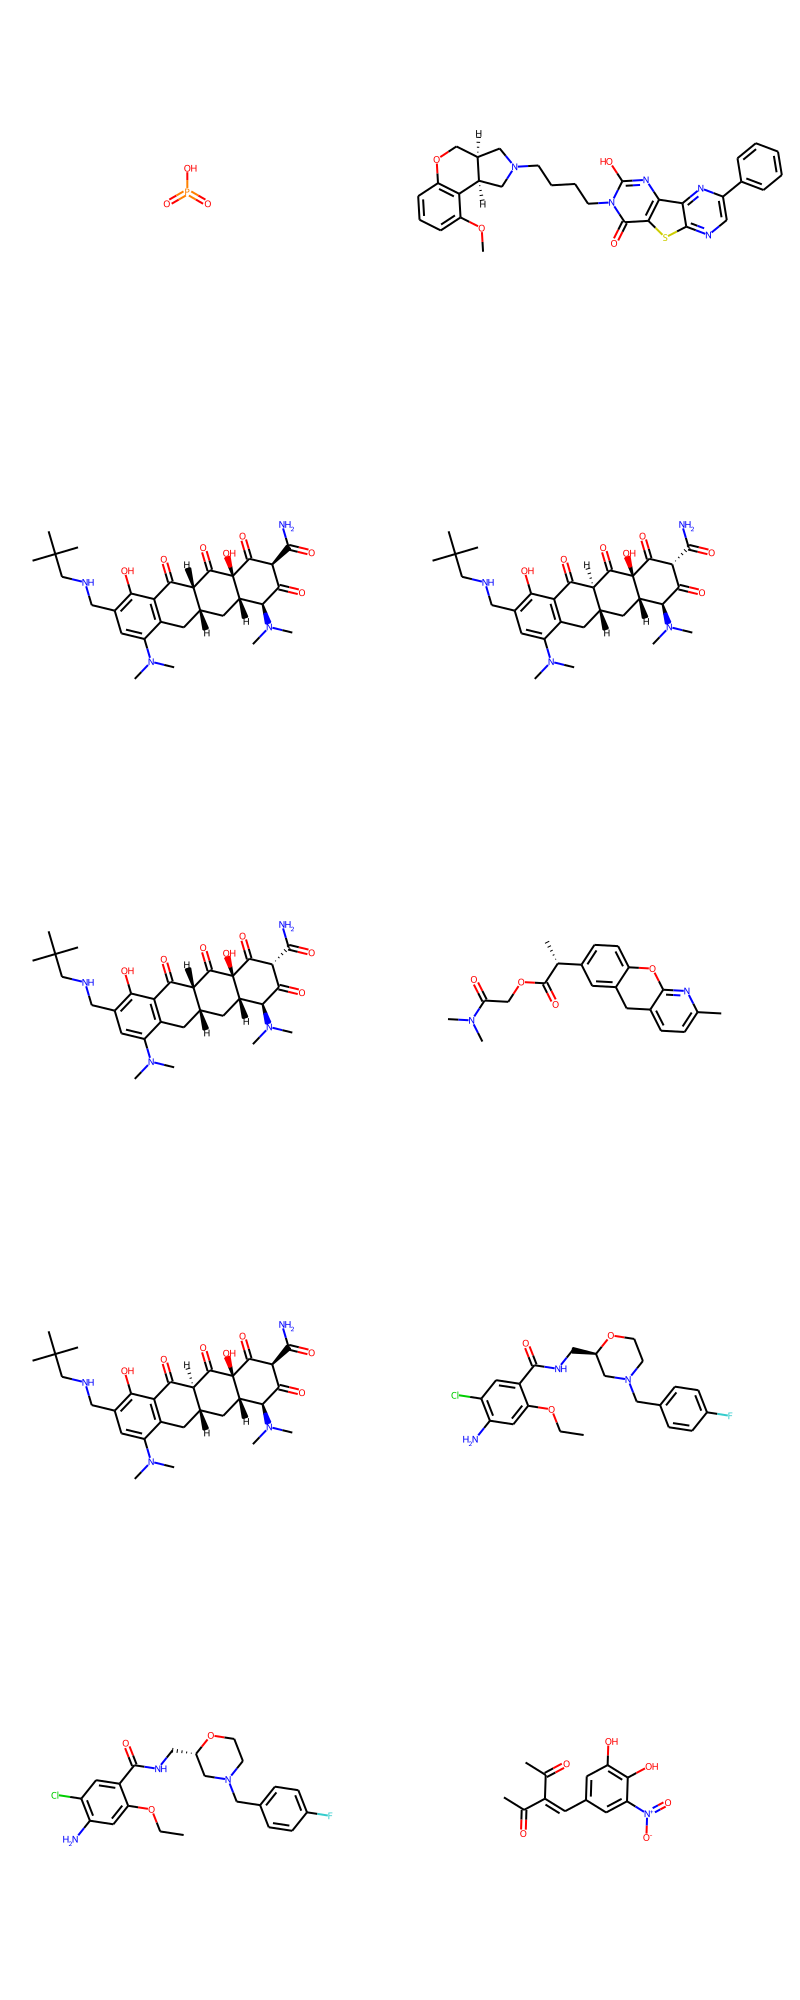

In [176]:
rdkit.Chem.Draw.MolsToGridImage(best_predicted_mols, molsPerRow=2, maxMols=100, subImgSize=(400, 400))